In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget  http://apache.osuosl.org/spark/spark-3.2.2/spark-3.2.2-bin-hadoop2.7.tgz   
!tar xf spark-3.2.2-bin-hadoop2.7.tgz  
!rm spark-3.2.2-bin-hadoop2.7.tgz    
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,038 kB]
Hit:1

In [2]:
#!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

--2022-11-24 09:06:04--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 99.84.160.25, 99.84.160.20, 99.84.160.46, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|99.84.160.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247880 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.2-s_2.12.jar’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.03s   

2022-11-24 09:06:04 (7.85 MB/s) - ‘graphframes-0.8.2-spark3.2-s_2.12.jar’ saved [247880/247880]



In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark/"
os.environ["DRIVE_DATA"] = "/content/gdrive/My Drive/BDF/data/"

!rm /content/spark
!ln -s /content/spark-3.2.2-bin-hadoop2.7 /content/spark

#!mv graphframes-0.8.1-spark3.0-s_2.12.jar /content/spark/jars/
!mv graphframes-0.8.2-spark3.2-s_2.12.jar /content/spark/jars/

!export SPARK_HOME=/content/spark
!export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin

!echo $SPARK_HOME
!env |grep  "DRIVE_DATA"

!ls -l /content/

rm: cannot remove '/content/spark': No such file or directory
/content/spark/
DRIVE_DATA=/content/gdrive/My Drive/BDF/data/
total 8
drwxr-xr-x  1 root root 4096 Nov 22 00:14 sample_data
lrwxrwxrwx  1 root root   34 Nov 24 09:06 spark -> /content/spark-3.2.2-bin-hadoop2.7
drwxr-xr-x 13 1000 1000 4096 Jul 11 16:16 spark-3.2.2-bin-hadoop2.7


In [4]:
# # Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
import findspark
findspark.init()
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext.getOrCreate() # We get the SparkContext
sc.addPyFile('/content/spark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar')
# We create a SparkSession object (or we retrieve it if it is already created)
spark = SparkSession \
.builder \
.appName("My application") \
.config("spark.some.config.option", "some-value") \
.master("local[4]") \
.getOrCreate()
sc = spark.sparkContext


Mounted at /content/gdrive


**EXERCISE 3 : WORD COUNT**

In [5]:
import re #Regular expressions
dfQuijote = spark.read.text(os.environ["DRIVE_DATA"] + "/quijote.txt")
dfQuijote.show(truncate=False)
def count_word(row): #count words in a string 
  result = len(re.findall(r'\w+', row[0]))
  return(result)
test = dfQuijote.rdd.map(count_word)
print("The File has {0} words".format(sum(test.collect())))

+---------------------------------------------------------------------------+
|value                                                                      |
+---------------------------------------------------------------------------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|
|                                                                           |
|This eBook is for the use of anyone anywhere at no cost and with           |
|almost no restrictions whatsoever.  You may copy it, give it away or       |
|re-use it under the terms of the Project Gutenberg License included        |
|with this eBook or online at www.gutenberg.net                             |
|                                                                           |
|                                                                           |
|Title: Don Quijote                                                         |
|                                                               

**EXERCISE 4.1 : PI**

In [38]:
import numpy as np
from pyspark.sql.functions import col,expr
import random
N = 100000
data = [(random.random(),random.random()) for _ in range(N)]
df = spark.createDataFrame(data , schema =["X","Y"])
df = df.withColumn("square", expr("X*X+Y*Y"))
df.show(10)
colsquare = col('square')
Pi  = 4*df.filter(colsquare<1).count()/N
print("The approximation of PI is   {0} ".format(Pi))

+------------------+-------------------+------------------+
|                 X|                  Y|            square|
+------------------+-------------------+------------------+
|0.8608611704168155| 0.8017250360648747| 1.383844988184634|
|0.9209875284849872|0.11215788526027781|0.8607974188509429|
|0.7949338123244742| 0.5133042547905068|0.8954010239627599|
|0.5826867561200484|0.11857216680210314|0.3535832144978505|
|0.8816700418650529| 0.5927552296135952|1.1287008249565902|
|0.1645531611316493| 0.7113093978141657|0.5330388022571696|
|0.9920632170735892|0.48233813378752055|1.2168395019760274|
| 0.650340114956127| 0.6339243330224384|0.8248023251190919|
|0.5800414698565535| 0.6860780621691845|0.8071512141431745|
|0.5144832181505655| 0.8627551279050695|1.0090393924850551|
+------------------+-------------------+------------------+
only showing top 10 rows

The approximation of PI is   3.14268 


**EXERCISE 4.2 INSPECT LOGS**

In [7]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

Saving syslog to syslog


In [8]:
from pyspark.sql.functions import array_contains
dfLog= spark.read.text("syslog")
num_lines = dfLog.count()
colvalue = col('value')
dfLogbadlines = dfLog.filter(colvalue.contains("WARNING") | colvalue.contains("ERROR") )
dfLogbadlines.show(15,truncate=False)
print("There is {0} bad lines out of  {1} lines  in total ".format(dfLogbadlines.count(),num_lines))

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**EXERCISE 5.1**

In [9]:
import re
from operator import add


rdd = sc.textFile(os.environ["DRIVE_DATA"] + "/quijote.txt")
words = rdd.flatMap(lambda x: re.findall(r'\w+', x)).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
keys = words.keys()
values = words.values()
print("There is {0} lines in the file .There is  {1} words in total and {2} different words ".format(rdd.count(),values.reduce(add),keys.count()))

There is 37861 lines in the file .There is  384442 words in total and 25280 different words 


**EXERCISE 5.2**

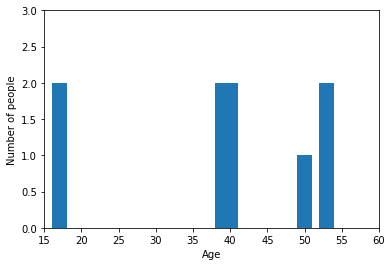

In [10]:
import matplotlib.pyplot as plt
people = sc.textFile(os.environ["DRIVE_DATA"] + "/people.txt")
dict_people = people.map(lambda x:(int(x.split('\t')[1]),1)).countByKey()
X = dict_people.keys()
Y = dict_people.values()
plt.bar(X,Y,width = 2)
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.xlim(15,60)
plt.ylim(0,3)
plt.show()

**EXERCISE 5.3**

In [11]:
patent = sc.textFile(os.environ["DRIVE_DATA"] + "/cite75_99.txt").cache()
header = patent.first()
rdd = patent.filter(lambda line : line!=header) #remove header


In [12]:
test = rdd.map(lambda x: ( int(x.split(',')[1]),1)).reduceByKey(lambda x, y: x + y).cache()

[(3557384, 13), (14040, 1), (3755824, 9), (3641592, 9)]

In [13]:
import numpy as np
test2 = rdd.map(lambda x:  (int(x.split(',')[0]),1)).cache()
cited = np.array(test.keys().collect())
citing = np.array(test2.keys().collect())
diff = list(set(citing) - set(cited))# those who are citing but  not cited

In [14]:
from pyspark.sql.types import StructField, StructType, IntegerType
columns = ["PatentNum","ncitations"]
schemaMarks = StructType([
    StructField("PatentNum", IntegerType(), True),
    StructField("ncitations", IntegerType(), True),
    ])
data = [(int(patent),0) for patent in diff]
added_df = spark.createDataFrame(data, schema = schemaMarks)
Dataframe_patent = spark.createDataFrame(test, schema = schemaMarks).union(added_df)

In [15]:
Dataframe_patent.show(5,truncate=False)

+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|3557384  |13        |
|14040    |1         |
|3755824  |9         |
|3641592  |9         |
|3706104  |5         |
+---------+----------+
only showing top 5 rows



**EXERCISE 11**

In [16]:
df = spark.read.option("multiline","true") \
        .json(os.environ["DRIVE_DATA"] + "/sw.txt")\
        .cache()
df.show() # read and show the file

+--------------------+--------------------+
|               links|               nodes|
+--------------------+--------------------+
|[{0, 1, 32}, {2, ...|[{#000000, DARTH ...|
+--------------------+--------------------+



In [17]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from graphframes import *
# Create a GraphFrame
nodes, links = df.select('nodes').collect(), df.select('links').collect()
data_vertex, data_edges = [], []
columns_1, columns_2 = ["id","value", "colour", "name"], ["src", "dst", "relationship"]
for i,row in enumerate(nodes[0][0]):
  liste = (i,row['value'],row['colour'],row['name'])
  data_vertex.append(liste)
for row in links[0][0]:
  liste = (row['source'],row['target'],row['value'])
  data_edges.append(liste)
vertex = sqlContext.createDataFrame(data_vertex).toDF(*columns_1)
edges = sqlContext.createDataFrame(data_edges).toDF(*columns_2)
g = GraphFrame(vertex, edges)
vertex.show()
edges.show()

/content/spark/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+---+-----+-------+--------------+
| id|value| colour|          name|
+---+-----+-------+--------------+
|  0|  190|#000000|   DARTH VADER|
|  1|  171|#bde0f6|         R2-D2|
|  2|  145|#A0522D|     CHEWBACCA|
|  3|   40|#eb5d00|          BB-8|
|  4|   62|#4f4fb1|       QUI-GON|
|  5|   25|#808080|   NUTE GUNRAY|
|  6|    4|#808080|          PK-4|
|  7|    5|#808080|         TC-14|
|  8|  148|#48D1CC|       OBI-WAN|
|  9|    4|#808080|        DOFINE|
| 10|   11|#808080|          RUNE|
| 11|    5|#808080|       TEY HOW|
| 12|   52|#191970|       EMPEROR|
| 13|   20|#808080|CAPTAIN PANAKA|
| 14|    9|#808080|    SIO BIBBLE|
| 15|   42|#9a9a00|       JAR JAR|
| 16|    4|#808080|       TARPALS|
| 17|    5|#808080|     BOSS NASS|
| 18|   75|#DDA0DD|         PADME|
| 19|   12|#808080|      RIC OLIE|
+---+-----+-------+--------------+
only showing top 20 rows

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  0|  1|          32|
|  2|  0|           2|
|  0| 20|          

In [18]:
from pyspark.sql.functions import col
print("There is {0} different characters .".format(g.vertices.count()))
print("There is {0} interactions .".format(g.edges.count()))
max_deg = g.degrees.sort(col('degree').desc()).first() # get the the highest degree
person = g.vertices.where(g.vertices['id']==max_deg['id']).collect()[0]

results = g.pageRank(resetProbability=0.01, maxIter=20) #page algorithm
max_rank = results.vertices.select("id", "pagerank").first()
person_rank = g.vertices.where(g.vertices['id']==max_rank['id']).collect()[0]

print("The personage with the most interactions is {0}  with  {1} interactions".format(person['name'],max_deg['degree']))
print("The personage with the highest rank is {0}: rank = {1}".format(person_rank['name'],max_rank['pagerank']))


There is 111 different characters .
There is 444 interactions .
The personage with the most interactions is DARTH VADER  with  52 interactions
The personage with the highest rank is KITSTER: rank = 0.5541619207953362


**EXERCISE 12.1**

In [19]:
!mkdir /tmp/data/
!cp "$DRIVE_DATA"apat63_99.txt.tar.bz2 "$DRIVE_DATA"cite75_99.txt.tar.bz2 /tmp/data
%cd /tmp/data
!ls
!tar -jxf apat63_99.txt.tar.bz2
!tar -jxf cite75_99.txt.tar.bz2
!rm /tmp/data/*.tar.bz2
!ls

/tmp/data
apat63_99.txt.tar.bz2  cite75_99.txt.tar.bz2
apat63_99.txt  cite75_99.txt


In [20]:
patent = sc.textFile("../tmp/data/cite75_99.txt").cache()
header = patent.first()
rdd = patent.filter(lambda line : line!=header) #remove header
test = rdd.map(lambda x: ( int(x.split(',')[1]),1)).reduceByKey(lambda x, y: x + y).cache()
import numpy as np
test2 = rdd.map(lambda x:  (int(x.split(',')[0]),1)).cache()
cited = np.array(test.keys().collect())
citing = np.array(test2.keys().collect())
diff = list(set(citing) - set(cited))# those who are citing but  not cited

In [21]:
from pyspark.sql.types import StructField, StructType, IntegerType
columns = ["PatentNum","ncitations"]
schemaMarks = StructType([
    StructField("PatentNum", IntegerType(), True),
    StructField("ncitations", IntegerType(), True),
    ])
data = [(int(patent),0) for patent in diff]
added_df = spark.createDataFrame(data, schema = schemaMarks)
Dataframe_patent = spark.createDataFrame(test, schema = schemaMarks).union(added_df)
Dataframe_patent.sort(col('ncitations')).show()


+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|  5810243|         0|
|  4761658|         0|
|  5810242|         0|
|  5810229|         0|
|  5810233|         0|
|  5810238|         0|
|  5810241|         0|
|  5810224|         0|
|  5810228|         0|
|  5810231|         0|
|  5810232|         0|
|  5810235|         0|
|  5810237|         0|
|  5810239|         0|
|  5810240|         0|
|  5810222|         0|
|  5810223|         0|
|  5810225|         0|
|  5810226|         0|
|  5810230|         0|
+---------+----------+
only showing top 20 rows



In [22]:
# Save the DataFrame using Parquet
Dataframe_patent.write.format("parquet")\
    .mode("overwrite")\
    .option("compression", "gzip")\
    .save("patent.parquet")

In [23]:
apat = spark.read.format("csv")\
                    .option("mode", "FAILFAST")\
                    .option("sep", ",")\
                    .option("inferSchema", "true")\
                    .option("header", "true")\
                    .load("../tmp/data/apat63_99.txt")
columns2 = ["PatentNum","Country","Year"]
Dataframe_apat = apat.select(expr("PATENT AS PatentNum"),expr("COUNTRY AS Country"),expr("GYEAR AS Year"))
Dataframe_apat.show()
# Save the DataFrame using Parquet
Dataframe_apat.write.format("parquet")\
    .mode("overwrite")\
    .option("compression", "gzip")\
    .save("apat.parquet")

+---------+-------+----+
|PatentNum|Country|Year|
+---------+-------+----+
|  3070801|     BE|1963|
|  3070802|     US|1963|
|  3070803|     US|1963|
|  3070804|     US|1963|
|  3070805|     US|1963|
|  3070806|     US|1963|
|  3070807|     US|1963|
|  3070808|     US|1963|
|  3070809|     US|1963|
|  3070810|     US|1963|
|  3070811|     US|1963|
|  3070812|     US|1963|
|  3070813|     US|1963|
|  3070814|     US|1963|
|  3070815|     US|1963|
|  3070816|     US|1963|
|  3070817|     US|1963|
|  3070818|     US|1963|
|  3070819|     US|1963|
|  3070820|     GB|1963|
+---------+-------+----+
only showing top 20 rows



**EXERCISE 12.2**

In [26]:
#Retrieve a DataFrame reading it from the Parquet format
apat = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .option("compression", "gzip")\
            .load("apat.parquet")
patent = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .option("compression", "gzip")\
            .load("patent.parquet")
apat.cache()
patent.cache()
apat = apat.withColumnRenamed("Country", "code")
#country codes
countries = spark.read.format("csv")\
                    .option("sep", "\t")\
                    .option("inferSchema", "true")\
                    .option("header", "false")\
                    .load(os.environ["DRIVE_DATA"] + "/country_codes.txt")
countries = countries.withColumnRenamed("_c0", "code")
countries.show() 

+----+-------------------+
|code|                _c1|
+----+-------------------+
|  AF|        Afghanistan|
|  AX|      Aland Islands|
|  AL|            Albania|
|  DZ|            Algeria|
|  AS|     American Samoa|
|  AD|            Andorra|
|  AO|             Angola|
|  AI|           Anguilla|
|  AQ|         Antarctica|
|  AG|Antigua and Barbuda|
|  AR|          Argentina|
|  AM|            Armenia|
|  AW|              Aruba|
|  AC|   Ascension Island|
|  AU|          Australia|
|  AT|            Austria|
|  AZ|         Azerbaijan|
|  BS|            Bahamas|
|  BH|            Bahrain|
|  BD|         Bangladesh|
+----+-------------------+
only showing top 20 rows



In [29]:
from pyspark.sql.functions import sum,avg,max,count
result = patent.join(apat,"PatentNum")
result = result.filter(col("ncitations")>0) #only those who are cited can count in the computation of the mean
resultgrouped = result.groupBy('Code','Year')\
.agg( count("PatentNum").alias("Patents"),\
      sum("ncitations").alias("TotalCitations"),\
      avg("ncitations").alias("AverageCitations"),\
      max("ncitations").alias("MaxCitations")\
      )
resultgrouped = countries.join(resultgrouped,"Code").withColumnRenamed("_c1", "Country").drop("Code").sort(col("Country"),col("Year")) #join on contry and sort 
resultgrouped.show(20)
resultgrouped.write.option("header",True).format("CSV").mode("overwrite").save("patents_groupedby_countries.csv") #Save on csv format

+-------------------+----+-------+--------------+-----------------+------------+
|            Country|Year|Patents|TotalCitations| AverageCitations|MaxCitations|
+-------------------+----+-------+--------------+-----------------+------------+
|            Algeria|1963|      2|             7|              3.5|           4|
|            Algeria|1968|      1|             2|              2.0|           2|
|            Algeria|1970|      1|             2|              2.0|           2|
|            Algeria|1972|      1|             1|              1.0|           1|
|            Algeria|1977|      1|             2|              2.0|           2|
|            Andorra|1987|      1|             3|              3.0|           3|
|            Andorra|1993|      1|             1|              1.0|           1|
|            Andorra|1998|      1|             1|              1.0|           1|
|Antigua and Barbuda|1978|      1|             6|              6.0|           6|
|Antigua and Barbuda|1979|  

**EXERCISE 12.3**

In [30]:
apat = spark.read.format("csv")\
                    .option("mode", "FAILFAST")\
                    .option("sep", ",")\
                    .option("inferSchema", "true")\
                    .option("header", "true")\
                    .option("nullValue", "null")\
                    .option("compression", "bzip2")\
                    .load(os.environ["DRIVE_DATA"] +"apat63_99.txt.tar.bz2")\
                    .rdd\
                    .repartition(8) #8 partitions
apat.cache()

MapPartitionsRDD[651] at coalesce at NativeMethodAccessorImpl.java:0

In [31]:
def spliting(Partition):
  for row in Partition:
    yield((row.COUNTRY , int(row.GYEAR)),1) # each (country,year) is a key with value 1
rdd_apat = apat.mapPartitions(spliting)
rdd_apat.cache()

PythonRDD[652] at RDD at PythonRDD.scala:53

In [32]:
def regroup(x,y):
  z = []
  if type(x) is list:
    for element in x:
      z.append(element)
  else:
    z.append(x)
  if type(y) is list:
    for element in y:
      z.append(element)
  else:
    z.append(y)  
  return sorted(z)

tmp1 = rdd_apat.reduceByKey(lambda x,y:x+y).cache()
tmp2 = tmp1.map(lambda x: (x[0][0],(x[0][1],x[1]))).cache()
groups =  tmp2.reduceByKey(regroup).sortByKey() #sort by country
groups.lookup('PA')

[[(1963, 2),
  (1964, 2),
  (1965, 1),
  (1966, 1),
  (1970, 1),
  (1971, 1),
  (1972, 6),
  (1974, 3),
  (1975, 5),
  (1976, 3),
  (1977, 2),
  (1978, 2),
  (1980, 2),
  (1982, 1),
  (1983, 1),
  (1985, 2),
  (1986, 1),
  (1987, 2),
  (1988, 1),
  (1990, 1),
  (1991, 2),
  (1993, 1),
  (1995, 1),
  (1996, 1),
  (1999, 1)]]

**EXERCISE 12.4**

In [33]:
apat = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .option("compression", "gzip")\
            .load("apat.parquet")
patent = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .option("compression", "gzip")\
            .load("patent.parquet")
apat.cache()
patent.cache()

DataFrame[PatentNum: int, ncitations: int]

In [34]:
from pyspark.sql.functions import sum,avg,max,count
from pyspark.sql.functions import col, expr, row_number

result = patent.join(apat,"PatentNum")
result = result.filter(col("ncitations")>0)
resultgrouped = result.groupBy('Country','Year')\
.agg( sum("ncitations").alias("TotalCitations"),\
      avg("ncitations").alias("AverageCitations"),\
      max("ncitations").alias("MaxCitations")\
      )
from pyspark.sql.window import Window
resultgrouped  = resultgrouped.withColumn("Diff", col("MaxCitations")-col("AverageCitations")).sort(col("Country"),col("Year"))
resultgrouped = resultgrouped.join(result,["Country","Year"],"inner")
# Specify the windows to partition the rows by the userId column
window = Window.partitionBy(col("Year"),col("Country")).orderBy(col("TotalCitations").desc())
# Create a column with the maximum score per user
colMax = max(col("TotalCitations")).over(window)
resultgrouped  = resultgrouped.withColumn("row",row_number().over(window)).filter(col("row") ==1).drop("row")
resultgrouped = resultgrouped.sort(col("Country"),col("Year")).drop("TotalCitations","ncitations")
resultgrouped.show()

+-------+----+----------------+------------+----+---------+
|Country|Year|AverageCitations|MaxCitations|Diff|PatentNum|
+-------+----+----------------+------------+----+---------+
|     AD|1987|             3.0|           3| 0.0|  4688621|
|     AD|1993|             1.0|           1| 0.0|  5193231|
|     AD|1998|             1.0|           1| 0.0|  5765303|
|     AE|1984|             5.0|           5| 0.0|  4482959|
|     AE|1985|            14.0|          14| 0.0|  4554981|
|     AE|1987|             3.0|           3| 0.0|  4663181|
|     AE|1989|             5.0|           7| 2.0|  4805221|
|     AE|1990|             2.0|           2| 0.0|  4909321|
|     AE|1991|             2.0|           3| 1.0|  4997041|
|     AE|1992|             4.0|           4| 0.0|  5104556|
|     AE|1993|             8.0|           8| 0.0|  5181569|
|     AE|1996|             1.0|           1| 0.0|  5580125|
|     AG|1978|             6.0|           6| 0.0|  4126850|
|     AG|1979|            14.0|         

In [35]:
resultgrouped.write.option("header",True).format("CSV").mode("overwrite").save("maxcitations_grouped_countries.csv")
#save

**EXERCISE 12.5**

In [36]:
apat = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .option("compression", "gzip")\
            .load("apat.parquet")
apat = apat.withColumn("Decade",expr("Year - Year % 10")).cache() #get the decade
def difference(df): #difference between two year for a same country
  v = df.Diff
  u = df.Patents
  for i,element in enumerate(u.values):
    if i > 0:
      v.iloc[i] = element-u.iloc[i-1]
  v.iloc[0] = 0
  return df.assign(Diff = v)

apat = apat.groupBy('Country','Decade')\
            .agg( count("PatentNum").alias("Patents"))\
            .withColumn("Diff",expr("Patents"))\
            .sort("Country","Decade")
apat = apat.groupBy('Country').applyInPandas(difference,schema ="Country string, Decade int, Patents int,Diff int")\
            
apat.show()

+-------+------+-------+----+
|Country|Decade|Patents|Diff|
+-------+------+-------+----+
|     AD|  1980|      1|   0|
|     AD|  1990|      5|   4|
|     AE|  1980|      7|   0|
|     AE|  1990|     11|   4|
|     AG|  1970|      2|   0|
|     AG|  1990|      7|   5|
|     AI|  1990|      1|   0|
|     AL|  1990|      1|   0|
|     AM|  1990|      2|   0|
|     AN|  1970|      1|   0|
|     AN|  1980|      2|   1|
|     AN|  1990|      5|   3|
|     AR|  1960|    135|   0|
|     AR|  1970|    239| 104|
|     AR|  1980|    184| -55|
|     AR|  1990|    292| 108|
|     AT|  1960|    950|   0|
|     AT|  1970|   2588|1638|
|     AT|  1980|   3057| 469|
|     AT|  1990|   3665| 608|
+-------+------+-------+----+
only showing top 20 rows



In [37]:
apat.write.option("header",True).format("CSV").mode("overwrite").save("exercise12.5.csv")
#save